<a href="https://colab.research.google.com/github/mz256/portfolio_optimisation_LSTM/blob/main/Many_to_one_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and data

In [1]:
!pip install yfinance &> /dev/null

In [2]:
import os, time
import datetime
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = yf.download('VTI AGG DBC ^VIX',
                    start='2006-01-01',
                    end='2021-12-14',
                    group_by='column',
                    progress=False)

In [4]:
close = data['Close']
close = close.dropna().loc['2006-02-06':'2020-04-30'] # DBC starts on 6 Feb 2006
close = close[['VTI','AGG','DBC','^VIX']].rename(columns={'VTI':'S_price','AGG':'B_price','DBC':'C_price','^VIX':'V_price'})
# close

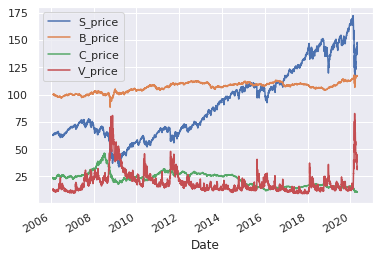

In [5]:
close.plot();

### Statistics of returns

Briefly inspect returns ($r_{i,t}= (p_{i,t}/p_{i,t-1})-1$) over the whole 2006-2020 period to reproduce rolling correlation plot in paper.

In [6]:
raw_returns = close.pct_change().fillna(value=0.)
raw_returns.columns = raw_returns.columns.str.rstrip('_price')
# raw_returns

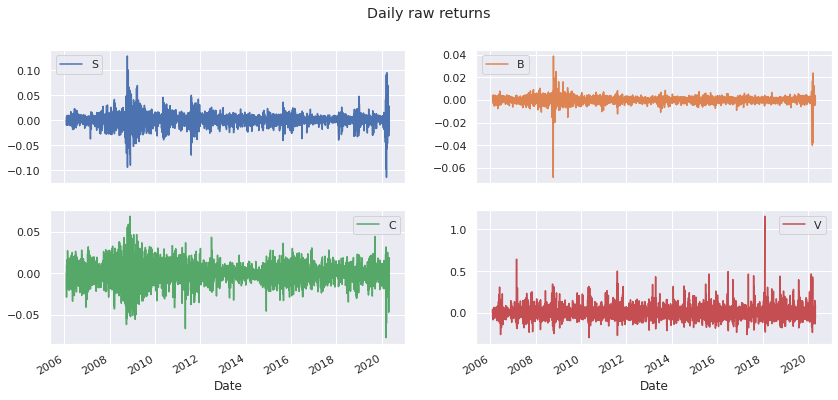

In [7]:
raw_returns.plot(subplots=True, layout=(2,2), figsize=(14,6), title='Daily raw returns');

Distribution and pairwise covariation of returns. Note that this plot shows some potential outliers (but let's leave outlier analysis for later).

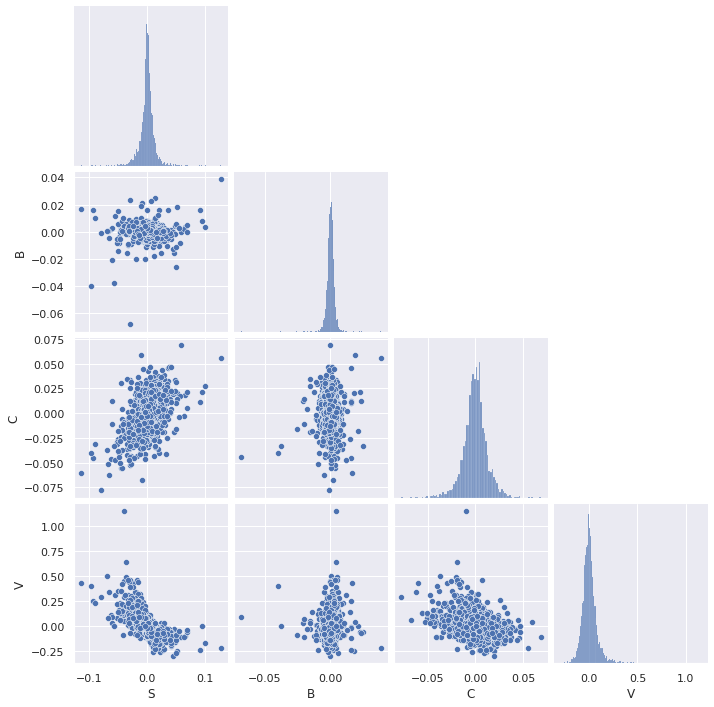

In [8]:
sns.pairplot(raw_returns, corner=True);

The plot shows that the returns for the 4 ETFs are (individually) roughly normal and show little (static) correlation. The most evident exception is between the stock and volatility indices, where a higher return for Stocks predicts lower return on the VIX (explanation?).

This is indeed confirmed by computing the static and rolling correlations.

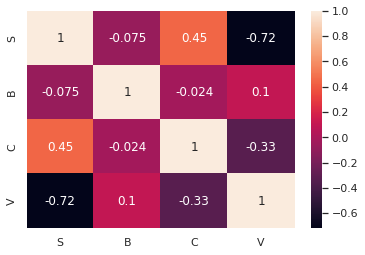

In [9]:
sns.heatmap(raw_returns.corr(), annot=True);

Compute the 50-day rolling correlation of the ETF returns.

In [10]:
def rolling_corr(df, window):
    cols = list(df.columns)
    pairs = list(it.combinations(cols, 2))
    result = pd.DataFrame()
    for pair in pairs:
        name = f"{pair[0]} & {pair[1]}"
        result[name] = df[list(pair)].rolling(window).corr().iloc[0::2,-1].droplevel(1, axis=0)
    return result

rolling_corrs = rolling_corr(raw_returns, 50)
#rolling_corrs

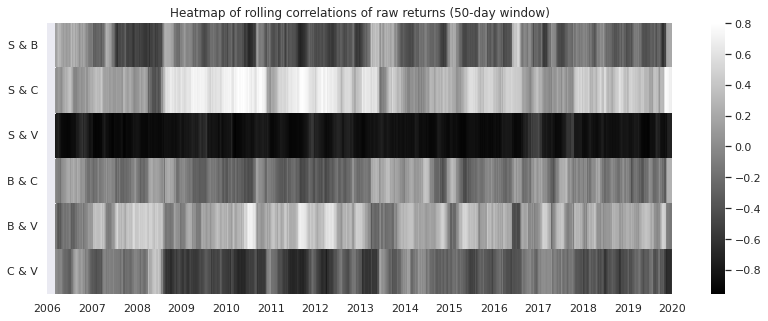

In [11]:
fig, ax = plt.subplots(1,1, figsize=(14,5))
xticks = np.linspace(0, len(rolling_corrs), 15)
xticklabels = np.arange(2006, 2021)
ax = sns.heatmap(rolling_corrs.transpose(), cmap='gist_gray', xticklabels=xticklabels)
ax.set_xticks(xticks);
ax.set_xlabel(None);
ax.set_title('Heatmap of rolling correlations of raw returns (50-day window)');
plt.xticks(rotation=0);
plt.yticks(rotation=0);

## Splitting

Eventually I want to use a TimeSeries CV strategy, ideally with an initial training set 2006-2010 and retraining every 2 years (for an overall test set 2010-2020). A TimeSeriesSplit achieves a similar split with `n_split=6` and disregarding the first split.

In [12]:
tscv = TimeSeriesSplit(n_splits=6)
for train_index, test_index in tscv.split(close):
    # print(f"Training: {len(train_index)}")
    # print(f"Test: {len(test_index)}")
    print(f"Training end: {close.index[train_index[-1]].strftime('%d/%m/%Y')}")
    print(f"Test end: {close.index[test_index[-1]].strftime('%d/%m/%Y')}", end='\n\n')

Training end: 26/02/2008
Test end: 08/03/2010

Training end: 08/03/2010
Test end: 15/03/2012

Training end: 15/03/2012
Test end: 28/03/2014

Training end: 28/03/2014
Test end: 08/04/2016

Training end: 08/04/2016
Test end: 19/04/2018

Training end: 19/04/2018
Test end: 30/04/2020



For now, let's just manually divide the dataset in 5 years for training, 6 months validation (10%) and 2 years test.

In [13]:
close_train = close.loc[:'2010-06-30'] # 5 years
close_valid = close.loc['2010-07-01':'2010-12-31'] # 0.5 years
close_test = close.loc['2011-01-01':'2012-12-31'] # 2 years
close_train.shape, close_valid.shape, close_test.shape

((1108, 4), (128, 4), (502, 4))

# Single split analysis

## Training set statistics

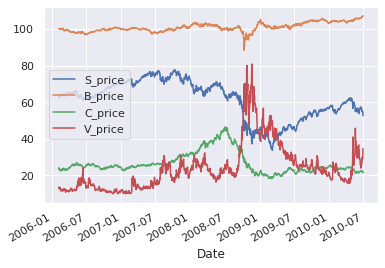

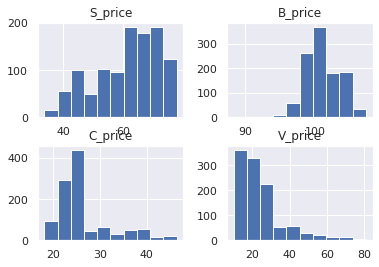

In [14]:
close_train.plot();
close_train.hist();

Raw closing prices are unsurprisingly non-stationary and non-Normal. We can check the former condition with a simple function.

In [15]:
def check_stationary(df, names):
    length = len(df.columns)
    for i in range(length):
        X = df.iloc[:,i]
        result = adfuller(X)
        print(f"{names[i]}: ADF Statistic: {result[0]:.2f}, p-value: {result[1]:.3f}")

names = ['S_price','B_price','C_price','V_price','S','B','C','V']
check_stationary(close_train, names[:4])

S_price: ADF Statistic: -1.04, p-value: 0.739
B_price: ADF Statistic: -1.46, p-value: 0.551
C_price: ADF Statistic: -1.15, p-value: 0.697
V_price: ADF Statistic: -2.04, p-value: 0.269


A log-transform helps with normality (and it could help with non-stationarity, depending on its cause). NB: approaching normally-distributed data makes scaling more meaningful as well.

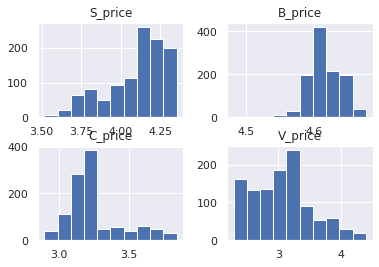

In [16]:
# np.log(close_train).plot();
np.log(close_train).hist();

In [17]:
check_stationary(np.log(close_train), names[:4])

S_price: ADF Statistic: -1.17, p-value: 0.686
B_price: ADF Statistic: -1.57, p-value: 0.501
C_price: ADF Statistic: -1.21, p-value: 0.668
V_price: ADF Statistic: -1.86, p-value: 0.349


### Validation and test sets

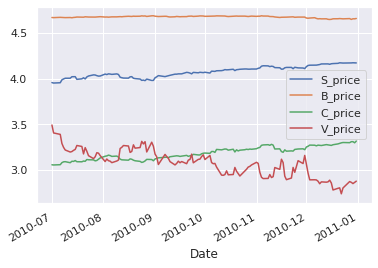

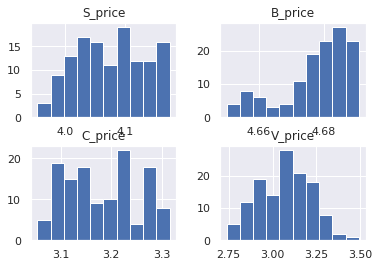

In [18]:
np.log(close_valid).plot();
np.log(close_valid).hist();

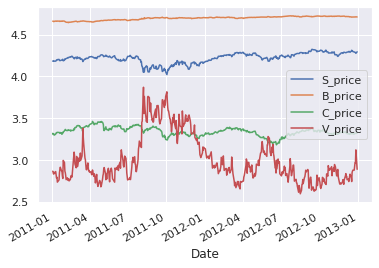

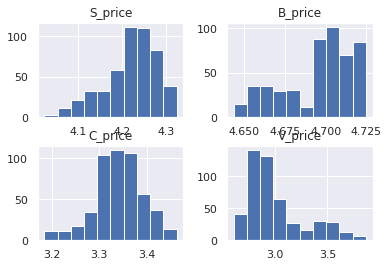

In [19]:
np.log(close_test).plot();
np.log(close_test).hist();

## Dataset preparation and scaling

Prepare data by extracting returns, **log-transforming and scaling** both prices and returns.

Scaling strategy: 
- scale before slicing
- standardisation (made meaningful by "normalisation" of features prior to scaling) preferred over minmax, as more robust wrt drift in validation and test sets
- scaling: 
  - returns as well as prices, although the former were in reasonable range, in order to equate their variances (desirable in DNN models where we expect to learn from both with equal importance)
  - only prices

p.s. by splitting and computing returns in separate functions I lose the first day of returns in valid and test sets. Can fix.

In [20]:
def prepare_data(close, scaler=None, train=False):
    """Extracts returns, log-transform both prices and returns, scales prices"""
    ## input
    # close: (train_sz, n_features) dataframe of daily closing prices
    ## output
    # data: (len(train), n_features) ndarray of (scaled) log-prices and log-returns
    # returns: raw returns

    # extract raw returns
    returns = close.pct_change().fillna(value=0.)

    # transform to log-price and log(1+return)~return
    logclose = np.log(close)
    logreturns = np.log(1+returns)

    if train:
        scaler = StandardScaler()
        logclose = scaler.fit_transform(logclose)
        data = np.concatenate((logclose, logreturns.to_numpy()), axis=1)
        return data, returns, scaler, (logclose, logreturns)

    else:
        try:
            logclose = scaler.transform(logclose)
        except:
            raise ValueError("Must provide a scaler object if train=False")
        data = np.concatenate((logclose, logreturns.to_numpy()), axis=1)
        return data, returns, (logclose, logreturns)

The following achieves similar performance, but more volatile portfolio weights.

In [21]:
def prepare_data_v2(close, scaler=None, train=False):
    """Extracts returns, log-transform AND SCALES both prices and returns"""
    ## input
    # close: (train_sz, n_features) dataframe of daily closing prices
    ## output
    # data: (len(train), n_features) ndarray of (scaled, log-) prices and returns
    # returns: raw returns

    # extract raw returns
    returns = close.pct_change().fillna(value=0.)

    # transform to log-price and log(1+return)~return
    logclose = np.log(close)
    logreturns = np.log(1+returns)

    # concatenate
    data = np.concatenate((logclose.to_numpy(), logreturns.to_numpy()), axis=1)

    # scale both prices and returns in training set
    if train:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        return data, returns, scaler, (logclose, logreturns)

    else:
        try:
            data = scaler.transform(data)
        except:
            raise ValueError("Must provide a scaler object if train=False")
        return data, returns, (logclose, logreturns)

In [22]:
data_train, returns_train, ss, _ = prepare_data(close_train, train=True)
data_valid, returns_valid, _ = prepare_data(close_valid, ss)
data_test, returns_test, _ = prepare_data(close_test, ss)

Let's have a look at the data we will train on.

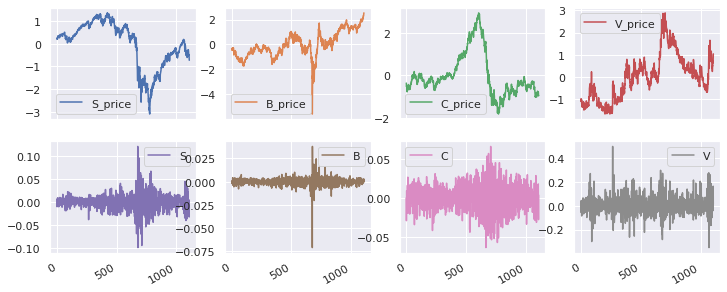

In [23]:
pd.DataFrame(data_train, columns=names).plot(subplots=True, layout=(2,4), figsize=(12,5));

Check that log-returns are stationary.

In [24]:
check_stationary(pd.DataFrame(data_train[:,4:]), names[4:])

S: ADF Statistic: -19.53, p-value: 0.000
B: ADF Statistic: -7.51, p-value: 0.000
C: ADF Statistic: -34.05, p-value: 0.000
V: ADF Statistic: -11.09, p-value: 0.000


## Slicing

There are various ways to slice the data. Which is more appropriate depends on the type of problem we want to set up for the model to solve. 

- Here we try a **many-to-one** framework, whereby we use a rolling lookback window of 50 days to "predict" the portfolio weights for the 51st day which would maximise the long-term Sharpe ratio. *(Uncertain: In this case we slice as below and we can use a stateless LSTM.)*

- Another possibility would be to set up a **many-to-many** problem where the model computes the portfolio returns for all 50 days of the lookback and we ask it to maximise the Sharpe for each sample.

In [25]:
# just to see the data
pd.DataFrame(data_train, index=close_train.index, columns=names)

,S_price,B_price,C_price,V_price,S,B,C,V
Date,,,,,,,,
2006-02-06,0.255152,-0.316296,-0.362871,-1.059709,0.000000,0.000000,0.000000,0.000000
2006-02-07,0.202896,-0.345594,-0.511165,-0.970437,-0.009784,-0.000699,-0.029352,0.041313
2006-02-08,0.241182,-0.366535,-0.532710,-1.094791,0.007169,-0.000499,-0.004264,-0.057548
2006-02-09,0.230999,-0.341406,-0.485432,-1.046492,-0.001907,0.000599,0.009358,0.022352
2006-02-10,0.242029,-0.429416,-0.578254,-1.088065,0.002065,-0.002099,-0.018373,-0.019239
...,...,...,...,...,...,...,...,...
2010-06-24,-0.506499,2.263721,-0.858196,0.721878,-0.020779,-0.000844,0.002282,0.099995
2010-06-25,-0.479264,2.322695,-0.766916,0.632122,0.005099,0.001407,0.018067,-0.041537
2010-06-28,-0.496756,2.401197,-0.821486,0.667430,-0.003275,0.001872,-0.010801,0.016340


In order to feed the data into an RNN model (here with LSTM cells) we: 
- slice the data to set up supervised learning framework:
  - the predictor consists of subsequences (or subarrays) of `n_lag` timesteps (from `t-n_lag` to `t-1`) and `n_output` features, each shifted by 1 timestep.
  - we don't have a proper target, but we still collect the corresponding vector of **raw** returns at each sample (i.e. at time `t`) to compute the Sharpe.
- serve minibatches, each comprising `bs` such sequences.

Additional considerations:
- The paper claims to be using a batch size of 64, while the lookback is 50. I think this means they are not linking up samples across consecutive batches. This type of slicing imposes the use of a stateless LSTM. The memory of the model lasts for 50 timesteps, and it is reset for the next batch.

In [26]:
def slice_chunks(data_arr, return_df, n_lag):
    X_train = []
    rt_train = []

    for i in range(n_lag, len(data_arr)):
        X_train.append(data_arr[i-n_lag:i,:])
        rt_train.append(return_df.iloc[i].to_numpy())

    return np.array(X_train), np.array(rt_train)

X_train, rt_train = slice_chunks(data_train, returns_train, n_lag=50)
X_valid, rt_valid = slice_chunks(data_valid, returns_valid, n_lag=50)
X_test, rt_test = slice_chunks(data_test, returns_test, n_lag=50)

print(f"Train chunks: {X_train.shape}, {rt_train.shape}")
print(f"Valid chunks: {X_valid.shape}, {rt_valid.shape}")
print(f"Test chunks: {X_test.shape}, {rt_test.shape}")

Train chunks: (1058, 50, 8), (1058, 4)
Valid chunks: (78, 50, 8), (78, 4)
Test chunks: (452, 50, 8), (452, 4)


Now cast chunks as Tensors and build DataLoaders to serve them. No shuffling in order to preserve temporal ordering.

In [27]:
bs = 64

def make_dl(X, rt, bs):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(rt))
    return DataLoader(ds, shuffle=False, batch_size=bs, drop_last=False) # drop last if BatchNorm added

train_dl = make_dl(X_train, rt_train, bs=bs)
valid_dl = make_dl(X_valid, rt_valid, bs=bs)
test_dl = make_dl(X_test, rt_test, bs=bs)

print(next(iter(train_dl))[0].size(), next(iter(train_dl))[1].size())

torch.Size([64, 50, 8]) torch.Size([64, 4])


## Modeling

### Model

In [28]:
n_input = 8 # data features
n_hidden = 64 # LSTM features
n_output = 4 # assets
n_layers = 1

In [29]:
class SharpeLSTM(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers=1, p_drop=0.5):
        super().__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.n_layers = n_layers

        # computation layers
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, batch_first=True).float()
        self.h_o = nn.Linear(n_hidden, n_output)

        # activation/regularisation layers
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=2)
        self.dropout = nn.Dropout(p_drop) # may pass drop_prob as input
    
    def forward(self, xb):
        bs = xb.size(0)
        xb = xb.float()

        # initialise hidden and cell states for each batch
        #hidden = tuple(torch.zeros(self.n_layers, bs, self.n_hidden) for _ in range(2))
        hn = torch.zeros(self.n_layers, bs, self.n_hidden)
        nn.init.xavier_uniform_(hn) # added to cure overfitting
        cn = torch.zeros(self.n_layers, bs, self.n_hidden)
        nn.init.xavier_uniform_(cn)

        # forward pass
        lstm_out, (hn, cn) = self.lstm(xb, (hn,cn))
        hn = self.dropout(hn) # 1x64x64
        wb = self.softmax(self.h_o(hn)).squeeze() # 64x4
        return wb, (hn, cn)

### Loss

In [30]:
def compute_Rp(w, r):
    Rp = [torch.dot(w[i], r[i].float()) for i in range(r.shape[0])] # this method retains gradients
    return torch.stack(Rp)

def sharpe_loss(wb, rb, recip=False):
    #### Inputs
    # wb: (bs, n_output) tensor of portfolio weights
    # rb: (bs, n_output) tensor of returns
    #### Output (recall SGD minimises loss)
    # negative Sharpe ratio

    Rp_batch = compute_Rp(wb, rb) # 64
    Rp_mean = torch.mean(Rp_batch)
    Rp_std = torch.std(Rp_batch)
    sharpe = Rp_mean / Rp_std

    if recip is False:
        return -sharpe, (Rp_mean.detach(), Rp_std.detach())
    else:
        return 1/sharpe, (Rp_mean.detach(), Rp_std.detach())

### Evaluation metrics

In [31]:
# add

## Training and validation

In [32]:
def train_epoch(model, loss_fn, opt, train_dl):
    """Routine to train model for one epoch"""
    model.train() # call to nn.Module to set model.training=True for Dropout layer

    losses = []
    for xb, rb in train_dl:
        # print(model.training)
        wb, _ = model(xb)
        loss, _ = loss_fn(wb, rb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(loss.detach())

    epoch_loss = torch.stack(losses).mean()
    return epoch_loss

@torch.no_grad()
def validate_epoch(model, loss_fn, val_dl):
    """Routine to evaluate model on validation set"""
    model.eval() # call to nn.Module to set model.training=False for Dropout layer

    w_valid = []
    r_valid = []
    for xb, rb in val_dl:
        # print(model.training)
        wb, _ = model(xb)
        w_valid.append(wb)
        r_valid.append(rb)

    w_valid = torch.cat(w_valid)
    r_valid = torch.cat(r_valid)
    Rp_valid = compute_Rp(w_valid, r_valid) # (dim_valid - n_lag) portfolio returns

    # metric = Sharpe ratio
    epoch_score = Rp_valid.mean() / Rp_valid.std()

    return epoch_score, Rp_valid, (w_valid, r_valid)

def train_model(epochs, model, loss_fn, opt, train_dl, val_dl, verbose=False):
    """Routine for model training and evaluation"""
    history = []
    for epoch in range(epochs):
        start_time = time.time()

        # train one epoch and evaluate on validation set
        loss_train = train_epoch(model, loss_fn, opt, train_dl)
        val_results = validate_epoch(model, loss_fn, val_dl)

        m, s = divmod(time.time() - start_time, 60)
        train_time = f"{int(m)}min {int(s)}sec"

        # log history
        hist = {'train_loss' : loss_train, 'valid_score': val_results[0], 'time' : train_time}
        history.append(hist)

        if verbose:
            print(f"train loss: {hist['train_loss']:.2f}, val score: {hist['valid_score']:.2f}, time: {hist['time']}")
    
    return history

Instantiate all quantities and check validation set performance prior to training **as a baseline**.

In [33]:
model = SharpeLSTM(n_input, n_hidden, n_output, p_drop=0.5)
loss_fn = sharpe_loss
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

We can check the cumulative returns during the validation period are near zero, as expected. The weights are allocated randomly (all near 25%).

The Sharpe ratio for the validation set: 0.06


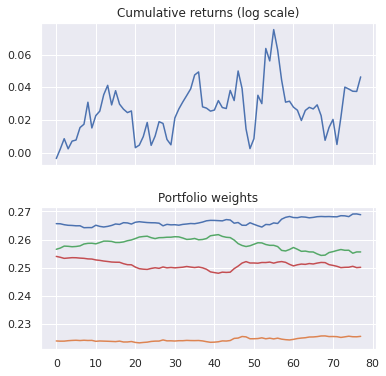

In [34]:
sharpe_valid, Rp_valid, (w_valid, r_valid) = validate_epoch(model, loss_fn, valid_dl)
print(f"The Sharpe ratio for the validation set: {sharpe_valid:.2f}")

fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'hspace':0.3})
axs[0].plot(torch.log(1+Rp_valid).cumsum(dim=0));
# same as axs[0].plot((1+Rp_valid).cumprod(dim=0)-1)
axs[0].set_title('Cumulative returns (log scale)');
axs[1].plot(pd.DataFrame(w_valid, columns=[names[4:]]));
axs[1].set_title('Portfolio weights');

In [35]:
%%time
history = train_model(50, model, loss_fn, opt, train_dl, valid_dl, verbose=False)

CPU times: user 25.2 s, sys: 254 ms, total: 25.5 s
Wall time: 25.4 s


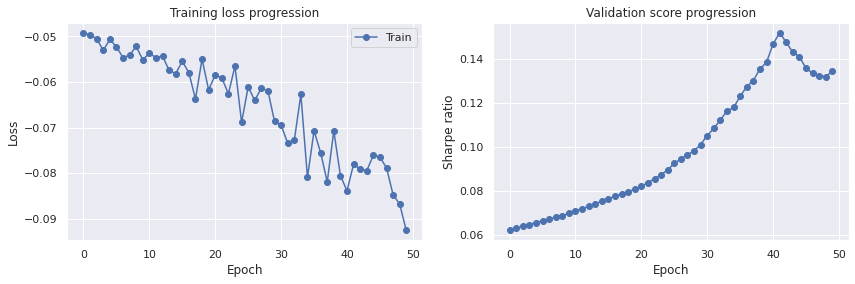

In [36]:
def plot_results(history):
    train_losses = [epoch['train_loss'] for epoch in history]
    valid_scores = [epoch['valid_score'] for epoch in history]

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    ax1.plot(train_losses, '-bo')
    ax1.legend(['Train'])
    ax1.set_title('Training loss progression')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2.plot(valid_scores, '-bo')
    ax2.set_title('Validation score progression')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Sharpe ratio')

plot_results(history)

## Diagnostics

**The model overfits very easily.**

Changes already made to curb overfitting problem:
- Added Xavier weight initialisation for hidden states.
- Added Dropout layer between LSTM and Dense with various `p_drop`. Calls to `model.train()` and `model.eval()` added to use Dropout only during training.
- Hyperparameter influence (yet to be CV'ed):
  - Use extremely small learning rate (1e-4). E.g. a rate of 0.01 leads to no predictive power whatsoever.
  - Weight decay in Adam optimiser might help.

Check validation set performance again (Sharpe) and inspect cumulative returns and asset allocations.

The final Sharpe ratio for the validation set: 0.13


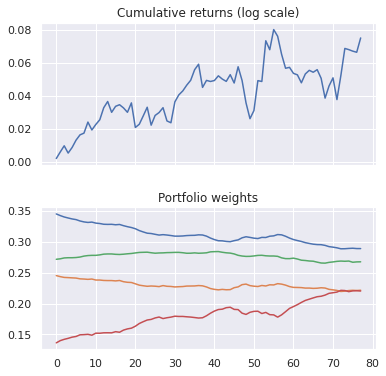

In [37]:
sharpe_valid, Rp_valid, (w_valid, r_valid) = validate_epoch(model, loss_fn, valid_dl)
print(f"The final Sharpe ratio for the validation set: {sharpe_valid:.2f}")

fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'hspace':0.3})
axs[0].plot(torch.log(1+Rp_valid).cumsum(dim=0));
axs[0].set_title('Cumulative returns (log scale)');
axs[1].plot(pd.DataFrame(w_valid, columns=[names[4:]]));
axs[1].set_title('Portfolio weights');

Check if the model's parameters blew up (sign that the gradients blew up at some point). I don't think we need to check the reverse, since the model was training nicely (i.e. the training loss was decreasing), meaning that the gradients were not vanishing. In general vanishing/exploding gradients are a problem of RNNs which is solved by LSTMs, so don't really expect it here. 

In [38]:
for param in model.parameters():
    print(param.shape)

torch.Size([256, 8])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([4, 64])
torch.Size([4])


Check that the model parameters are not blowing up or vanishing.

In [39]:
param_list = []
for param in model.parameters():
    param_list.append(param)
    print(param.mean())

tensor(-0.0016, grad_fn=<MeanBackward0>)
tensor(-0.0009, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(-0.0033, grad_fn=<MeanBackward0>)
tensor(-0.0131, grad_fn=<MeanBackward0>)


## Evaluation on test set

The final Sharpe ratio for the validation set: 0.06


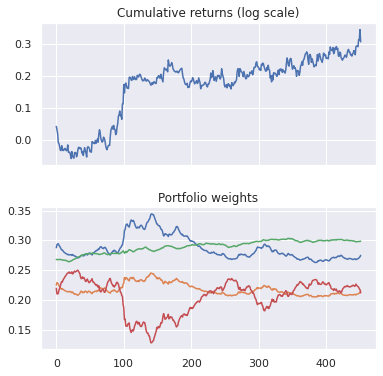

In [40]:
sharpe_test, Rp_test, (w_test, r_test) = validate_epoch(model, loss_fn, test_dl)
print(f"The final Sharpe ratio for the validation set: {sharpe_test:.2f}")

fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'hspace':0.3})
axs[0].plot(torch.log(1+Rp_test).cumsum(dim=0));
axs[0].set_title('Cumulative returns (log scale)');
axs[1].plot(pd.DataFrame(w_test, columns=[names[4:]]));
axs[1].set_title('Portfolio weights');

Model outputs (the portfolio weights) are very volatile. I think that adding **Temporal Activation Regularisation (TAR)** might help. Its rationale is to make the LSTM outputs change little from one timestep to the next.

## Doubts

- What kind of optimisation problem does maximising Sharpe pose? See [SE](https://math.stackexchange.com/questions/3813346/transforming-the-sharpe-ratio-into-an-efficient-convex-optimization) and [this blog](https://docs.mosek.com/modeling-cookbook/cqo.html#maximizing-the-sharpe-ratio) for talk about turning it into convex problem.

# Time series CV split